In [1]:
import torch
from torch.cuda import is_available
# import torch.optim
from torch.nn import MSELoss, BCELoss
import numpy as np
import matplotlib.pyplot as plt
import cv2
from torch.utils.data import Dataset, DataLoader
from utils import ims, imshow
from conv3d import Conv3D, PEI

### The outputs after each layer: 
`dim = (batch_size, channels, frames, height, width)`
* Conv3d layer 1: `(1, 16, 1, 160, 120)`

* Conv3d layer 2: `(1, 32, 1, 160, 120)`

* Conv3d layer 3: `(1, 16, 1, 160, 120)`

* Conv3d layer 4: `(1, 1, 1, 160, 120)`


In [2]:
torch.cuda.is_available()

True

In [3]:
model = Conv3D()
device = 'cuda:0'
print(device)
model.to(device)

cuda:0


Conv3D(
  (conv1): Sequential(
    (0): Conv3d(1, 16, kernel_size=(3, 1, 1), stride=(1, 1, 1))
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool3d(kernel_size=(1, 1, 1), stride=(1, 1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
  )
  (conv2): Sequential(
    (0): Conv3d(16, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool3d(kernel_size=(1, 1, 1), stride=(1, 1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
  )
  (conv3): Sequential(
    (0): Conv3d(32, 16, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool3d(kernel_size=(1, 1, 1), stride=(1, 1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
  )
  (conv4): Sequential(
    (0): Conv3d(16, 1, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (1): BatchN

In [4]:
from pytictoc import TicToc
t = TicToc()

In [5]:
t.tic()
dataset = PEI(7, angle=0, keyposes=[1,3,5,7,9,11,13,15])
t.toc()

Elapsed time is 341.061780 seconds.


In [6]:
len(dataset)

2508

In [7]:
train_dl = DataLoader(dataset,batch_size=1,shuffle=True)

In [9]:
#Loss
criterion = MSELoss()
#Optimizer
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.001,weight_decay=0.9)

## Training

In [10]:
from tqdm.notebook import tqdm

In [14]:
#Epochs
n_epochs = 3

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0

    #Training
    for images,y in tqdm(train_dl):
        images,y = images.to(device), y.to(device)
        # print('images.shape',images.shape)
        optimizer.zero_grad()

        out = model(images)
        # print(out.view(out.shape[3],out.shape[4]).shape,y.view)
        loss = criterion(out.view(out.shape[3],out.shape[4]), y.view(y.shape[1],y.shape[2]))
        loss.backward()

        optimizer.step()
        train_loss += loss.item()
          
    train_loss = train_loss/len(train_dl)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

  0%|          | 0/2508 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 0.054241


  0%|          | 0/2508 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 0.055616


  0%|          | 0/2508 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 0.054343


## Check
`1687 images (4 experiments, from keypose 1,3,5,7,9,11,13,15)`

In [15]:
def ims(model_out,actual):
    fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(12,4))
    axes[0].imshow(model_out,cmap='gray',vmin=0,vmax=1)
    axes[0].set_title('Model')
    axes[1].imshow(actual,cmap='gray',vmin=0,vmax=1)
    axes[1].set_title('Average')
    plt.show()


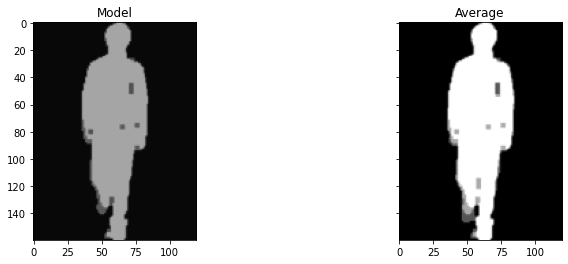

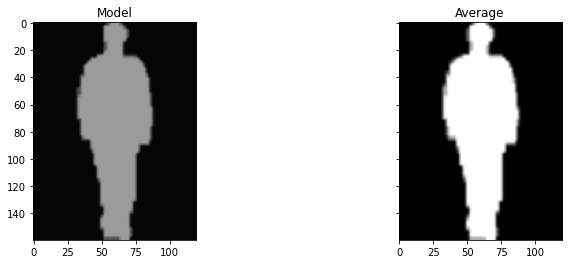

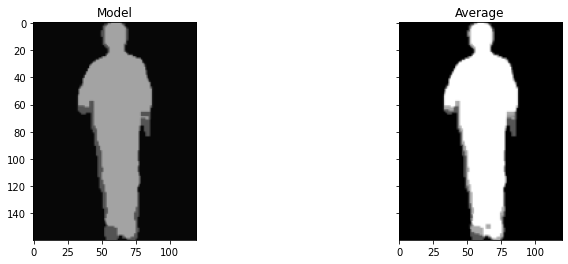

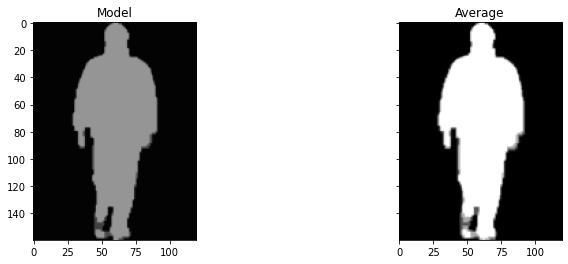

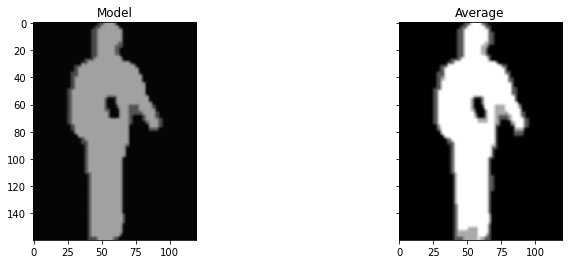

In [16]:

for i,data in enumerate(train_dl):
    if i==5:
        break
    output = model(data[0].to(device=device))
    data[0] = data[0].reshape(data[0].shape[2],160,120)
    output = output.view(output.shape[2],160, 120)
    # print(output.shape)
    output = output.cpu().detach().numpy()
    output = np.mean(output,axis=0)
    ims(output,data[1].reshape(160,120))


### Check one sample

# TEST DATA: ANGLE 90, KEYPOSE 6

In [31]:
test_ds = PEI(1,angle=90,keyposes=[8])

In [32]:
test_dl = DataLoader(test_ds,batch_size=1,shuffle=True)

<class 'torch.Tensor'> torch.Size([1, 1, 3, 160, 120])


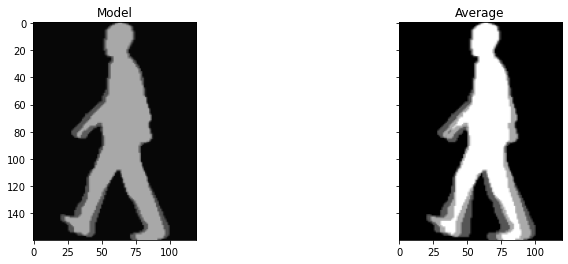

In [35]:
dataiter = iter(test_dl)
images, y = dataiter.next()
images = images.to('cpu',dtype=torch.float)
print(type(images),images.shape)

#Sample outputs
output = model(images.to(device=device))
images = images.cpu().numpy().reshape(images.shape[2],160,120)
output = output.view(output.shape[2],160, 120)
output = output.cpu().detach().numpy()
output = np.mean(output,axis=0)

ims(output,y.view(160,120))

<ipython-input-36-a377d4ca0743>:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


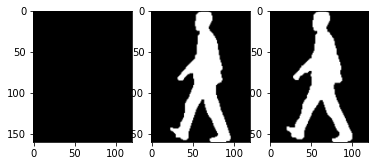

In [36]:
fig,ax = plt.subplots(nrows=1,ncols=3)
ax[0].imshow(images[0],cmap='gray')
ax[1].imshow(images[1],cmap='gray')
ax[2].imshow(images[2],cmap='gray')
fig.show()